<h1 align='center'>Customer Churn Classification Project</h1>

## Business Objective:
There are three ways in which business increase their revenue stream and these are,
- Upsell to excisting customers
- Acquire new customers
- Increase customer retention

In this project we will focus on the third point which is customer churn prediction. Our goal is to build a machine learning model capable of predicting customers who will churn in the future so that the business can put in adequate measures to keep these customers in order to increase revenue.

### Data Understanding

The following describes the columns present in the data.

Gender -- Whether the customer is a male or a female

SeniorCitizen -- Whether a customer is a senior citizen or not

Partner -- Whether the customer has a partner or not (Yes, No)

Dependents -- Whether the customer has dependents or not (Yes, No)

Tenure -- Number of months the customer has stayed with the company

Phone Service -- Whether the customer has a phone service or not (Yes, No)

MultipleLines -- Whether the customer has multiple lines or not

InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)

OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

Contract -- The contract term of the customer (Month-to-Month, One year, Two year)

PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

MonthlyCharges -- The amount charged to the customer monthly

TotalCharges -- The total amount charged to the customer

Churn -- Whether the customer churned or not (Yes or No)

### Import necessary Libraries

In [282]:
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Other Utilities
from warnings import filterwarnings
filterwarnings('ignore')

### Load Datasets

In [283]:
# Load Environment Variables
config = dotenv_values('.env')

Server_name = config.get('Server')
Database_name = config.get('Database')
Username = config.get('Login')
PassWord = config.get('Password')

# Create Database Connection
connection_string = f"DRIVER={{SQL Server}};SERVER={Server_name};DATABASE={Database_name};UID={Username};PWD={PassWord}"

connection = pyodbc.connect(connection_string)

In [284]:
query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'
model_df1 = pd.read_sql(query, connection)
model_df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [285]:
model_df1.shape

(3000, 21)

In [286]:
# Load dataset from GitHub
model_df2 = pd.read_csv('https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv')
model_df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [287]:
model_df2.shape

(2043, 21)

In [288]:
# Concatinate model dataframe
full_model_df = pd.concat([model_df1, model_df2], ignore_index=True)
full_model_df.shape

(5043, 21)

In [289]:
# Load Excel file
test_df = pd.read_excel('Telco-churn-second-2000.xlsx')
test_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [290]:
test_df.shape

(2000, 20)

## Hypothesis

### Null Hypothesis: The average churn rate for customers who contact tech support is not significantly different from the average churn rate for all customers.

### Alternate Hypothesis: The average churn rate for customers who contact tech support is significantly lower than the average churn rate for all customers.

## Questions

1. What is the total number of customers by churn status?
2. What is the total number of customers by gender?
3. What is the total number of customers that churn given their gender?
4. How much total charges was accumulated given the customer churn status?
5. What is the total number of customers given tech support status?
6. Which payment method do customers prefer most?

## Exploratory Data Analysis (EDA)

In [291]:
# Check the structure of the dataset
full_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


We are able to see the data type, and the number of non-null values for each column in the data set. Total Charges column is currently an object and must be converted to a float.

In [292]:
# Check for missing values
full_model_df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [293]:
# Check the percentage of missing values for each column
(full_model_df.isnull().sum()/len(full_model_df))*100

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        5.334127
InternetService      0.000000
OnlineSecurity      12.908983
OnlineBackup        12.908983
DeviceProtection    12.908983
TechSupport         12.908983
StreamingTV         12.908983
StreamingMovies     12.908983
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.099147
Churn                0.019829
dtype: float64

- Considering the percentage of missing values in the MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies columns we will have to fill the missing values.
- Missing values in the TotalCharges and Churn must be dropped since the percentage of missing values is not very significant.

In [294]:
full_model_df.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          5
InternetService        3
OnlineSecurity         5
OnlineBackup           5
DeviceProtection       5
TechSupport            5
StreamingTV            5
StreamingMovies        5
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4884
Churn                  4
dtype: int64

- We view the number of unique values in all the columns in the dataset.

In [295]:
full_model_df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [296]:
full_model_df['SeniorCitizen'].unique()

array([False, True], dtype=object)

- The true and false values in the columns must be changed to 1 and 0.

In [297]:
full_model_df['SeniorCitizen'].replace({True:1,False:0}, inplace=True)

In [298]:
full_model_df['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

- The true and false values in the column must be changed to yes and no.

In [299]:
full_model_df['Partner'].replace({True:'Yes',False:'No'}, inplace=True)

In [300]:
full_model_df['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

- The true and false values in the column must be changed to yes and no.

In [301]:
full_model_df['Dependents'].replace({True:'Yes',False:'No'}, inplace=True)

In [302]:
full_model_df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [303]:
full_model_df['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [304]:
full_model_df['PhoneService'].replace({True:'Yes',False:'No'}, inplace=True)

In [305]:
full_model_df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

- The true and false values in the column must be changed to yes and no

In [306]:
full_model_df['MultipleLines'].replace({True:'Yes',False:'No'}, inplace=True)

In [307]:
full_model_df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

- The values in the InternetService column are exaustive and uniform.

In [308]:
full_model_df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

- The true and false values in the column must be changed to yes and no

In [309]:
full_model_df['OnlineSecurity'].replace({True:'Yes',False:'No'}, inplace=True)

In [310]:
full_model_df['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

- The true and false values in the column must be changed to yes and no

In [311]:
full_model_df['OnlineBackup'].replace({True:'Yes',False:'No'}, inplace=True)

In [312]:
full_model_df['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

- The true and false values in the column must be changed to yes and no

In [313]:
full_model_df['DeviceProtection'].replace({True:'Yes',False:'No'}, inplace=True)

In [314]:
full_model_df['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

- The true or false values in the column must be changed to yes and no

In [315]:
full_model_df['TechSupport'].replace({True:'Yes',False:'No'}, inplace=True)

In [316]:
full_model_df['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

- The true and false values in the column must be changed to yes and no

In [317]:
full_model_df['StreamingTV'].replace({True:'Yes',False:'No'}, inplace=True)

In [318]:
full_model_df['StreamingMovies'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

- The true and false values in the column must be changed to yes and no

In [319]:
full_model_df['StreamingMovies'].replace({True:'Yes',False:'No'}, inplace=True)

In [320]:
full_model_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [321]:
full_model_df['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

- The true and false values in the column must be changed to yes and no.

In [322]:
full_model_df['PaperlessBilling'].replace({True:'Yes',False:'No'}, inplace=True)

In [323]:
full_model_df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

- The values in the PaymentMethod column are exaustive and uniform.

In [324]:
full_model_df['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [325]:
full_model_df[full_model_df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
4670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
4754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


- The total charges column have values which have been converted to a string which must be cast back in to a float.
- Three rows in the dataset have empty string as an amount for the total charges value and this must be corrected corrected to NA.

In [326]:
# Replace empty string with NA
full_model_df['TotalCharges'].replace(' ', np.nan, inplace=True)

# Convert the values in the Totalcharges column to a float
full_model_df['TotalCharges'] = full_model_df['TotalCharges'].transform(lambda x: float(x))

In [327]:
full_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [328]:
full_model_df['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

- The true or false values in the column must be changed to yes and no

In [329]:
full_model_df['Churn'].replace({True:'Yes',False:'No'}, inplace=True)

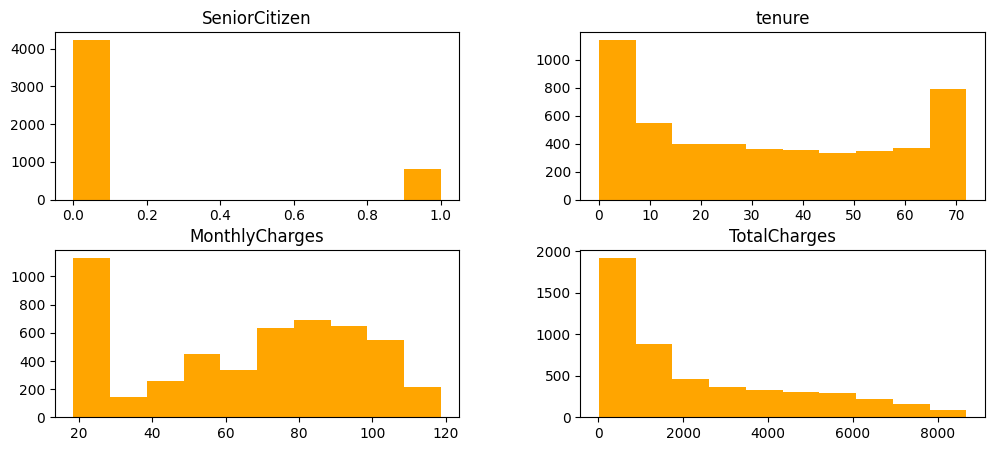

In [330]:
full_model_df.hist(figsize=(12, 5), grid=False, color='orange');

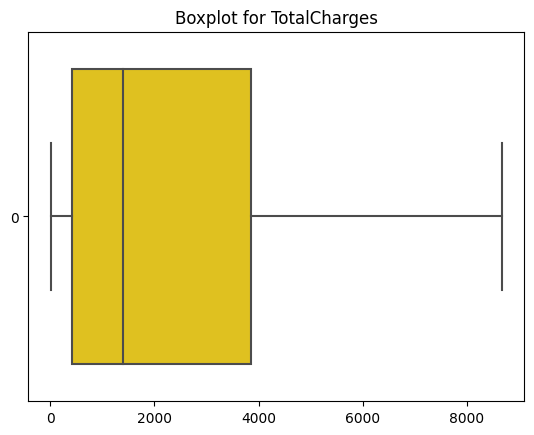

In [350]:
sns.boxplot(full_model_df['TotalCharges'], orient='horizontal', color='gold')
plt.title('Boxplot for TotalCharges')
plt.show()

The values in the total charges column are skewed to the right which is to say that there are extremely high values which drag the distribution to the right.

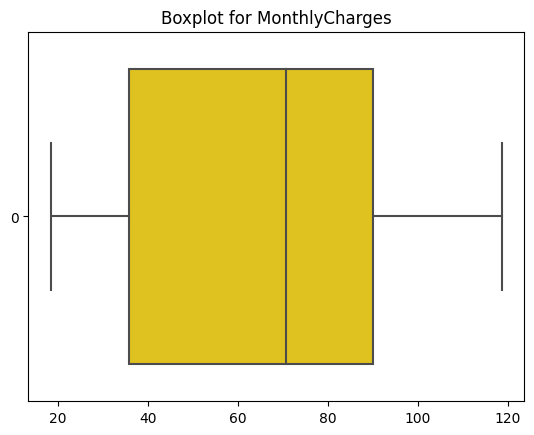

In [349]:
sns.boxplot(full_model_df['MonthlyCharges'], orient='horizontal', color='gold')
plt.title('Boxplot for MonthlyCharges')
plt.show()

The values in the MonthlyCharges column are approximately normally distributed

### Univariate Analysis

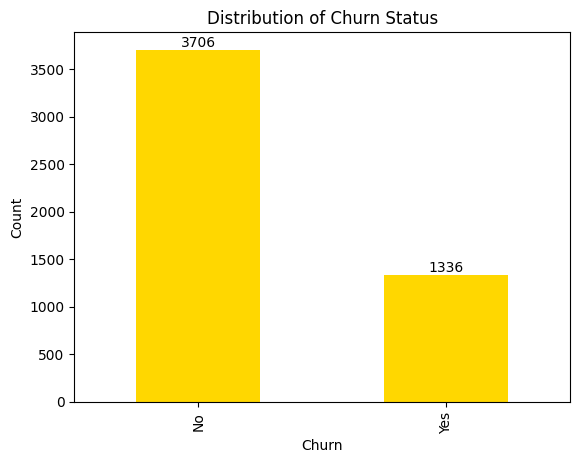

In [364]:
churn_count = full_model_df['Churn'].value_counts()
ax = churn_count.plot(kind='bar', color='gold')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Churn Status')
plt.ylabel('Count')
plt.show()

- The outcome value is inbalanced since more customers have been indicated not to have churned compared to customers who churned.

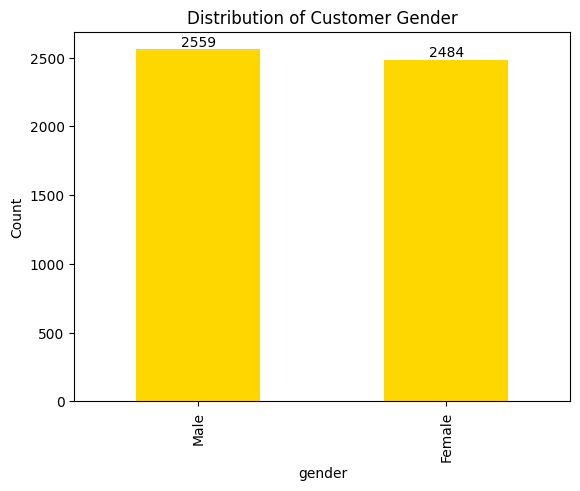

In [365]:
gender_count = full_model_df['gender'].value_counts()
ax = gender_count.plot(kind='bar', color='gold')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Gender')
plt.ylabel('Count')
plt.show()

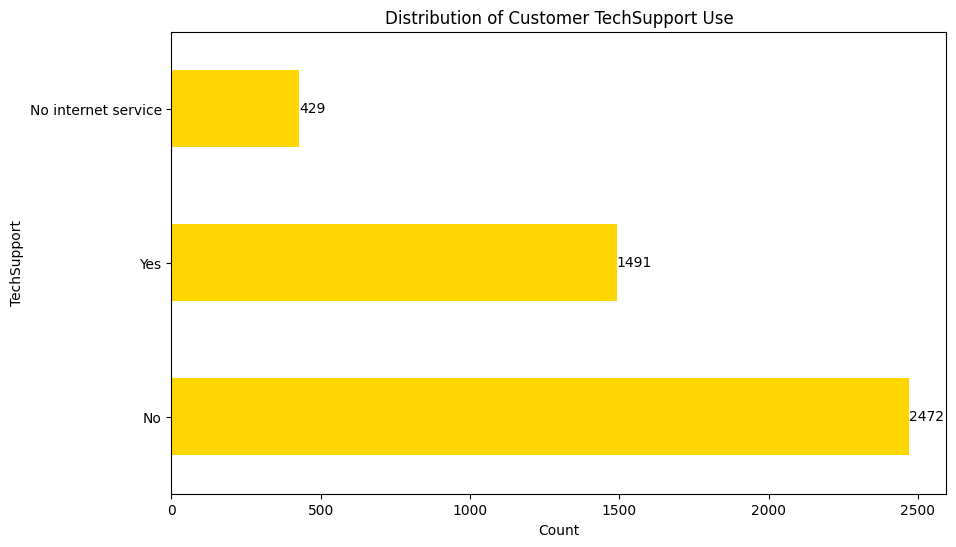

In [363]:
techsupport_count = full_model_df['TechSupport'].value_counts()
plt.figure(figsize=(10, 6))
ax = techsupport_count.plot(kind='barh', color='gold')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer TechSupport Use')
plt.xlabel('Count')
plt.show()

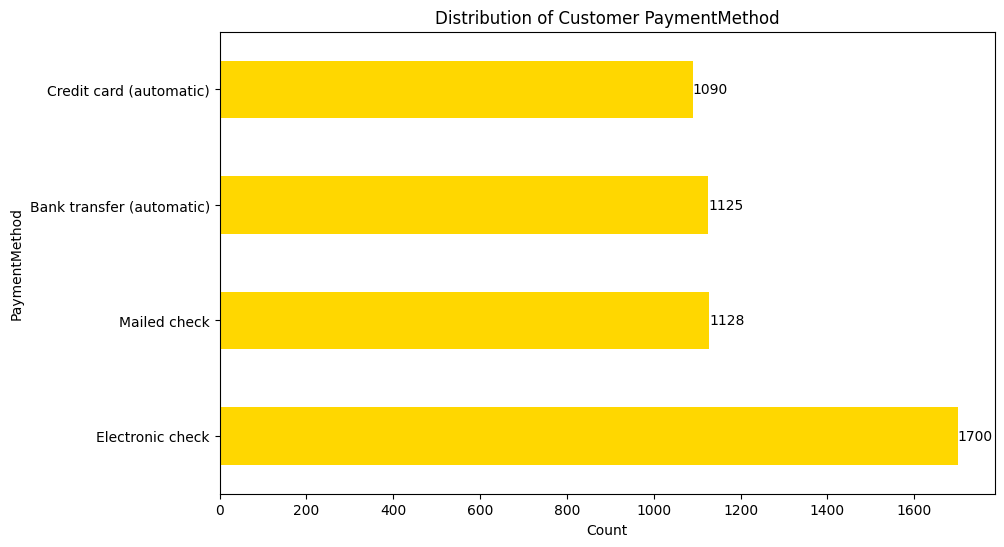

In [362]:
paymentmethod_count = full_model_df['PaymentMethod'].value_counts()
plt.figure(figsize=(10, 6))
ax = paymentmethod_count.plot(kind='barh', color='gold')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer PaymentMethod')
plt.xlabel('Count')
plt.show()

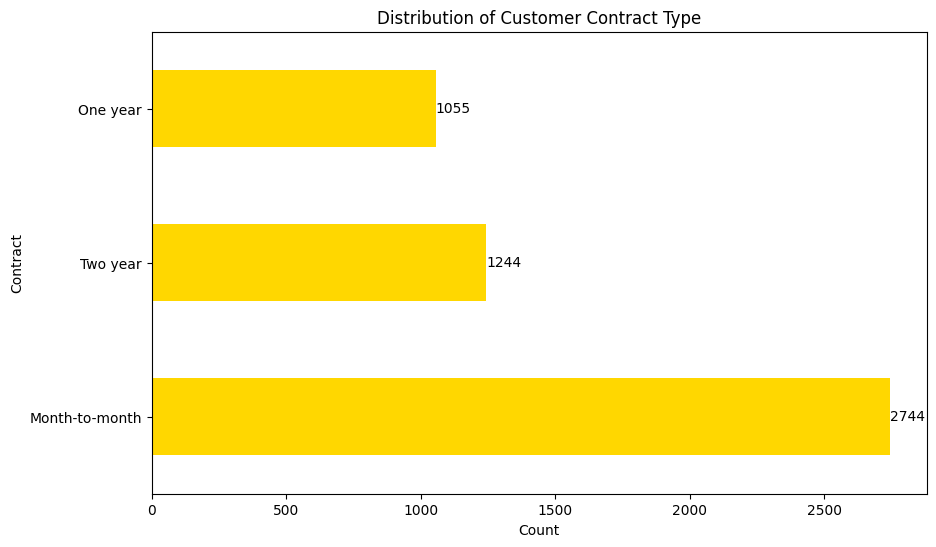

In [360]:
contract_count = full_model_df['Contract'].value_counts()
plt.figure(figsize=(10, 6))
ax = contract_count.plot(kind='barh', color='gold')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Customer Contract Type')
plt.xlabel('Count')
plt.show()

### Bivariate Analysis